<a href="https://colab.research.google.com/github/giuseppe-iacono-eng/telco-churn-prediction/blob/main/03_explain_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Shared project folder on Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pathlib
BASE_DIR = "/content/drive/MyDrive/colab_data/telco-churn"   # change if you like
DATA_DIR = f"{BASE_DIR}/data"
ARTIFACTS_DIR = f"{BASE_DIR}/artifacts"
pathlib.Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
pathlib.Path(ARTIFACTS_DIR).mkdir(parents=True, exist_ok=True)

RAW_PATH   = f"{DATA_DIR}/telco_raw.csv"
CLEAN_PATH = f"{DATA_DIR}/telco_clean.csv"
MODEL_PATH = f"{ARTIFACTS_DIR}/model.joblib"

Mounted at /content/drive


Loaded: /content/drive/MyDrive/colab_data/telco-churn/artifacts/model.joblib
Sanity ROC-AUC on full data (not a test split): 0.949


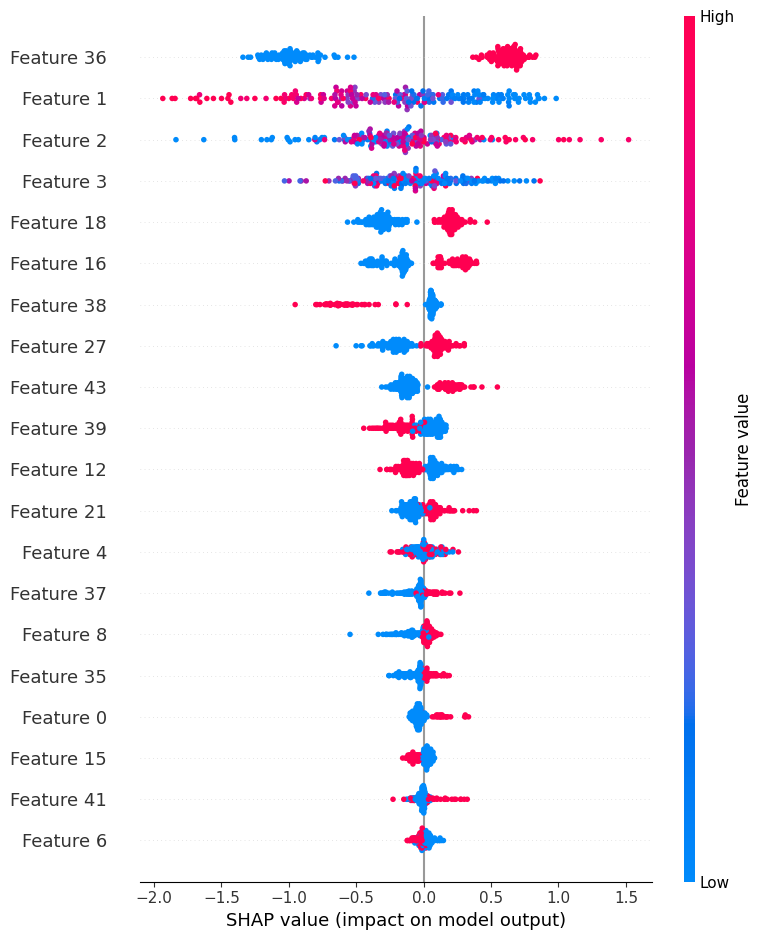

Example churn probability: 0.7587791681289673


/tmp/ipython-input-3021364697.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pipe.predict_proba(X_one)[:,1])


In [2]:
# Install deps
!pip -q install shap xgboost

import joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, shap
from sklearn.metrics import roc_auc_score

# Load data & model
df = pd.read_csv(CLEAN_PATH)
y = df["Churn"]; X = df.drop(columns=["Churn"])
pipe = joblib.load(MODEL_PATH)
print("Loaded:", MODEL_PATH)

# Recompute proba for AUC (sanity check)
proba = pipe.predict_proba(X)[:,1]
print("Sanity ROC-AUC on full data (not a test split):", round(roc_auc_score(y, proba),3))

# SHAP explanation (TreeExplainer on the XGB inside pipeline)
# Get encoded training matrix
prep = pipe.named_steps["prep"]
clf  = pipe.named_steps["clf"]
X_enc = prep.fit_transform(X)

explainer = shap.TreeExplainer(clf)
sv = explainer.shap_values(X_enc[:200])
shap.summary_plot(sv, X_enc[:200], show=True)  # shows in Colab

# Tiny predict helper (single customer dict)
import json
def predict_one(input_dict: dict) -> float:
    X_one = pd.DataFrame([input_dict])
    return float(pipe.predict_proba(X_one)[:,1])

# Example
example = {
    "gender":"Female","SeniorCitizen":0,"Partner":"No","Dependents":"No","tenure":5,
    "PhoneService":"Yes","MultipleLines":"No","InternetService":"Fiber optic",
    "OnlineSecurity":"No","OnlineBackup":"No","DeviceProtection":"No","TechSupport":"No",
    "StreamingTV":"No","StreamingMovies":"No","Contract":"Month-to-month",
    "PaperlessBilling":"Yes","PaymentMethod":"Electronic check","MonthlyCharges":85.0,
    "TotalCharges":200.0
}
print("Example churn probability:", predict_one(example))